<a href="https://colab.research.google.com/github/michael-diggin/rowing-classifier/blob/master/RowingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Let's import our modules

In [112]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.layers as kl
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.0.0


The images are split into a train set and a validation set, with equal number of images in each class.

In [0]:
train_path = '/content/drive/My Drive/train_images/'
val_path = '/content/drive/My Drive/val_images/'

In [114]:
import os 
for boat in ['Eights', 'Doubles', 'Singles', 'Quads', 'Fours', 'Pairs']:
  num = len(os.listdir(train_path + boat))
  print(f"Number of images of {boat}: {num}")

Number of images of Eights: 250
Number of images of Doubles: 250
Number of images of Singles: 250
Number of images of Quads: 250
Number of images of Fours: 250
Number of images of Pairs: 250


Let's take a look at one of the images, we'll rescale it when we train the model in order to save memory use

(400, 600, 3)


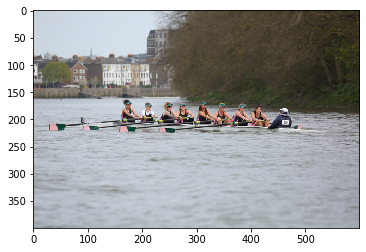

In [115]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image_path = train_path+'Eights/'+'1.jpg'
image = cv2.imread(image_path)
image.shape
print(image.shape)
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

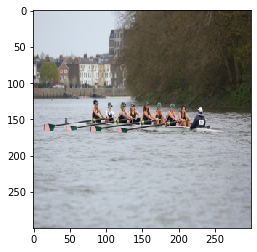

In [0]:

resized_img = cv2.resize(RGB_img, (224, 224))
plt.imshow(resized_img)


We can use the built in ImageDataGenerator class from keras to speed up our training - we can also use this to augment the training images. We won't do that here as it doesn't help with the accuracy that much.

In [0]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

batch_size = 64
train_generator = train_data_gen.flow_from_directory(train_path,
                                                     target_size=(224, 224),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

val_generator = val_data_gen.flow_from_directory(val_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


Found 1500 images belonging to 6 classes.
Found 336 images belonging to 6 classes.


Now let's define a model. 
We'll use a pretrained model - VGG16, trained on the imagenet dataset. We'll add two dense layers on top of this with a dropout layer in case of overfitting. We freeze the lower covolution layers but retain the features they've learnt to capture from images. 

In [0]:
num_classes = len(os.listdir(train_path))

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = tf.keras.models.Sequential()
for layer in base_model.layers:
  model.add(layer)
model.add(kl.GlobalAveragePooling2D())
model.add(kl.Dropout(0.25))
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dense(num_classes, activation='softmax'))

for layer in model.layers[:-4]:
  layer.trainable=False
model.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________

Next we compile the model and fit it on 100 epochs. Using the GPU provided on google colab this doesn't take too long. 

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
hist = model.fit_generator(train_generator,
                           epochs=100,
                           steps_per_epoch=1500//batch_size,
                           callbacks=[es],
                           validation_data=val_generator,
                           validation_steps=336//batch_size,
                           verbose=1)

Epoch 1/100
23/23 [==============================] - 25s 1s/step - loss: 1.2932 - accuracy: 0.5418 - val_loss: 1.2213 - val_accuracy: 0.5969
Epoch 2/100
23/23 [==============================] - 25s 1s/step - loss: 1.1021 - accuracy: 0.6141 - val_loss: 1.1077 - val_accuracy: 0.6219
Epoch 3/100
23/23 [==============================] - 24s 1s/step - loss: 0.9840 - accuracy: 0.6657 - val_loss: 1.0013 - val_accuracy: 0.6313
Epoch 4/100
23/23 [==============================] - 24s 1s/step - loss: 0.8819 - accuracy: 0.6886 - val_loss: 0.9691 - val_accuracy: 0.6250
Epoch 5/100
23/23 [==============================] - 24s 1s/step - loss: 0.8724 - accuracy: 0.6713 - val_loss: 0.8817 - val_accuracy: 0.7031
Epoch 6/100
23/23 [==============================] - 24s 1s/step - loss: 0.7755 - accuracy: 0.7403 - val_loss: 0.8359 - val_accuracy: 0.7250
Epoch 7/100
23/23 [==============================] - 24s 1s/step - loss: 0.7259 - accuracy: 0.7611 - val_loss: 0.7879 - val_accuracy: 0.7125
Epoch 8/100
2

We can plot a graph of the training and validation accuracy over each epoch. The model doesn't overfit but the validation accuracy does stop at around 0.85-0.86. Training continued as the model was still improving over the validation set, the loss was decreasing meaning the model was refining it's predictions.

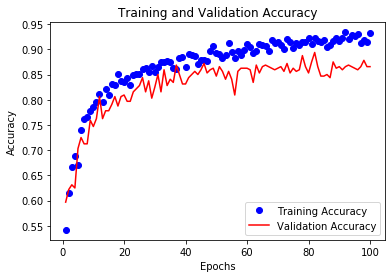

In [0]:
test_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
test_loss = hist.history['loss']
val_loss = hist.history['val_loss']

%matplotlib inline 
import matplotlib.pyplot as plt

epochs = range(1, len(test_acc)+1)
plt.plot(epochs, test_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
import h5py
model.save('/content/drive/My Drive/Colab Notebooks/rowing_1213.h5')

Next we define a few helper functions in order to get an accuracy of the model on images it hasn't seen yet. 

In [0]:
def map_to_classes(array):
    l = list(array)
    classes = ['Doubles', 'Eights','Fours', 'Pairs', 'Quads', 'Singles']
    index = l.index(max(l))
    return classes[index], max(l)

In [0]:
from tensorflow.keras.models import load_model
fit_model = load_model('/content/drive/My Drive/Colab Notebooks/rowing_1213.h5')

In [118]:
from tensorflow.keras.preprocessing.image import img_to_array
import random


def one_image():
    boat_type = random.choice(['Doubles', 'Eights', 'Pairs', 'Quads', 'Singles'])
    boat_path = '/content/drive/My Drive/rowing_images/' + boat_type + '/' 

    sample_image_path = random.choice(os.listdir(boat_path))
    path = boat_path + sample_image_path
    image = cv2.imread(path)
    #resize to 224x224
    resized_img = cv2.resize(image, (224, 224))
    colour_resized = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    img = img_to_array(colour_resized)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = img/225.
    prediction = fit_model.predict(img)[0]
    output, percent = map_to_classes(prediction)
    
    return boat_type == output

one_image()

True

In [0]:
def single_sim(n=100):

    num_right = 0
    for i in range(n):
        pred = one_image()
        if pred == True:
            num_right += 1
    return num_right
        

single_sim(100)

92

In [0]:
import numpy as np
from tqdm import tqdm

def model_accuracy(n=100):
    all_acc = np.zeros(n)
    for i in tqdm(range(n)):
        percent = single_sim(100)
        all_acc[i] = percent
    #avg_acc = np.mean(all_acc)
    return np.mean(all_acc)

We have just under 2,000 more images that we can use (in 5 of the 6 classes only). Here we run 100 simulations - each simulation involves picking a 100 random images from this extra set and getting a percentage accuracy. We then take the mean of these 100 values to get a 'test accuracy'. It returns 91% - not bad!

In [0]:
simulated_accuracy = model_accuracy(100)

In [0]:
simulated_accuracy

91.23

Now what we can do is visualize what area of the image the models uses to come up with it's predction. 

Quads 0.9957123


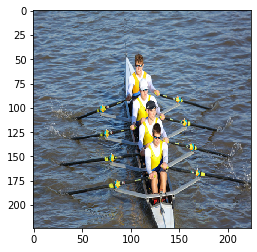

In [179]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

boat_type = random.choice(['Doubles', 'Eights', 'Pairs', 'Quads', 'Singles'])
img_path = '/content/drive/My Drive/rowing_images/' + boat_type + '/'
sample_image_path = random.choice(os.listdir(img_path))
img_path = img_path + sample_image_path

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor/255.

plt.imshow(img_tensor[0])

pred = fit_model.predict(img_tensor)
output, prob = map_to_classes(pred[0])
print(output, prob)


In [0]:
conv_layer = fit_model.get_layer("block5_conv3")
heatmap_model = tf.keras.models.Model([fit_model.inputs], [conv_layer.output, fit_model.output])

In [180]:
import tensorflow.keras.backend as K
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

(1, 14, 14)


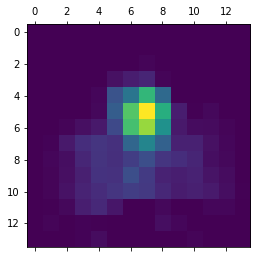

In [181]:
heatmap = heatmap[0]
plt.matshow(heatmap)

In [0]:
img = cv2.imread(img_path)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(RGB_img, (224, 224))

(224, 224, 3)


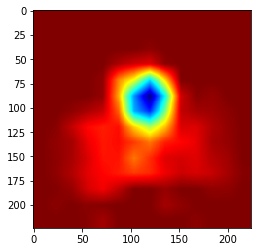

In [183]:
map_img = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
map_img = np.uint8(255*map_img)
map_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)

print(map_img.shape)
plt.imshow(map_img)

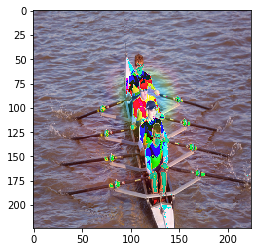

In [184]:
superimposed_img = np.uint8(.2*map_img + img)
plt.imshow(superimposed_img)